In [1]:
import numpy as np
import pandas as pd
import torch
import pickle
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.1 MB/s eta 0:00:00


## preprocessing


In [ ]:
! wget http://youcook2.eecs.umich.edu/static/YouCookII/youcookii_annotations_trainval.tar.gz

--2023-09-26 18:13:58--  http://youcook2.eecs.umich.edu/static/YouCookII/youcookii_annotations_trainval.tar.gz
Resolving youcook2.eecs.umich.edu (youcook2.eecs.umich.edu)... 141.212.115.67
Connecting to youcook2.eecs.umich.edu (youcook2.eecs.umich.edu)|141.212.115.67|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 337048 (329K) [application/octet-stream]
Saving to: ‘youcookii_annotations_trainval.tar.gz’

youcookii_annotatio 100%[===================>] 329.15K  1.28MB/s    in 0.3s    

2023-09-26 18:13:59 (1.28 MB/s) - ‘youcookii_annotations_trainval.tar.gz’ saved [337048/337048]



In [ ]:
!tar -xzvf youcookii_annotations_trainval.tar.gz

youcookii_annotations_trainval.json


In [ ]:
import json
# Define the file path
file_path = '/content/youcookii_annotations_trainval.json'

# Read the JSON file
with open(file_path, 'r') as json_file:
    json_data = json.load(json_file)

# Display the JSON data
print(json_data)

{'database': {'GLd3aX16zBg': {'duration': 241.62, 'subset': 'training', 'recipe_type': '113', 'annotations': [{'segment': [90, 102], 'id': 0, 'sentence': 'spread margarine on two slices of white bread'}, {'segment': [114, 127], 'id': 1, 'sentence': 'place a slice of cheese on the bread'}, {'segment': [132, 138], 'id': 2, 'sentence': 'place the bread slices on top of each other and place in a hot pan'}, {'segment': [139, 145], 'id': 3, 'sentence': 'flip the sandwich over and press down'}, {'segment': [173, 174], 'id': 4, 'sentence': 'cut the sandwich in half diagonally'}], 'video_url': 'https://www.youtube.com/watch?v=GLd3aX16zBg'}, 'xHr8X2Wpmno': {'duration': 206.86, 'subset': 'validation', 'recipe_type': '226', 'annotations': [{'segment': [47, 60], 'id': 0, 'sentence': 'pick the ends off the verdalago'}, {'segment': [67, 89], 'id': 1, 'sentence': 'combine lemon juice sumac garlic salt and oil in a bowl'}, {'segment': [91, 98], 'id': 2, 'sentence': 'chop lettuce and place it in a bowl'

In [ ]:
json_data['database']['GLd3aX16zBg']

{'duration': 241.62,
 'subset': 'training',
 'recipe_type': '113',
 'annotations': [{'segment': [90, 102],
   'id': 0,
   'sentence': 'spread margarine on two slices of white bread'},
  {'segment': [114, 127],
   'id': 1,
   'sentence': 'place a slice of cheese on the bread'},
  {'segment': [132, 138],
   'id': 2,
   'sentence': 'place the bread slices on top of each other and place in a hot pan'},
  {'segment': [139, 145],
   'id': 3,
   'sentence': 'flip the sandwich over and press down'},
  {'segment': [173, 174],
   'id': 4,
   'sentence': 'cut the sandwich in half diagonally'}],
 'video_url': 'https://www.youtube.com/watch?v=GLd3aX16zBg'}

## dataframe

In [ ]:
df = pd.DataFrame(columns=['Recipe','subset','recipe_type','segment','sentence','url'])

In [ ]:
lis = []
for key in list(json_data['database'].keys()):
  for sub in json_data['database'][key]['annotations']:
    new_instances = {'Recipe': key,'subset':json_data['database'][key]['subset'] ,'recipe_type': json_data['database'][key]['recipe_type'],'segment':sub['segment'],'sentence':sub['sentence'],'url':json_data['database'][key]['video_url']}
    lis.append(new_instances)


In [ ]:
df = pd.DataFrame(lis)

In [ ]:
df.head()

,Recipe,subset,recipe_type,segment,sentence,url
0,GLd3aX16zBg,training,113,"[90, 102]",spread margarine on two slices of white bread,https://www.youtube.com/watch?v=GLd3aX16zBg
1,GLd3aX16zBg,training,113,"[114, 127]",place a slice of cheese on the bread,https://www.youtube.com/watch?v=GLd3aX16zBg
2,GLd3aX16zBg,training,113,"[132, 138]",place the bread slices on top of each other an...,https://www.youtube.com/watch?v=GLd3aX16zBg
3,GLd3aX16zBg,training,113,"[139, 145]",flip the sandwich over and press down,https://www.youtube.com/watch?v=GLd3aX16zBg
4,GLd3aX16zBg,training,113,"[173, 174]",cut the sandwich in half diagonally,https://www.youtube.com/watch?v=GLd3aX16zBg


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer("bert-base-uncased", device=device)

In [ ]:
df['embeding'] = df['sentence'].apply(lambda x:model.encode([x]))

In [ ]:
df.iloc[2]['embeding']

##save and load dataframe

In [ ]:
## save the dataset


file_path = '/content/drive/My Drive/recpie2video/youcook.pkl'

with open(file_path, 'wb') as file:
    pickle.dump(df, file)


In [2]:
## load dataset
file_path = '/content/drive/My Drive/recpie2video/youcook.pkl'
with open(file_path, 'rb') as file:
    df = pickle.load(file)

## text similarities

In [16]:
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = SentenceTransformer("bert-base-uncased")

In [12]:
# from transformers import BertForTokenClassification

In [7]:
def similarity_mapping(text):
  input_emb = model.encode([NER_classification(text)])
  result=[[cosine_similarity(df.iloc[i]['embeding'], input_emb).item(), df.loc[i]['sentence'], i] for i in range(len(df))]
  collection=sorted(result, key=lambda x: x[0], reverse=True)[:5]
  return collection

In [18]:
collection = similarity_mapping("prepare the Chicken, Season both sides of the chicken breasts with salt and black pepper")

In [19]:
collection

[[0.8927954435348511,
  'season the chicken with poultry seasoning garlic powder onion powder black pepper and smoked paprika',
  10220],
 [0.8915717005729675,
  'season the chicken with salt pepper chicken seasoning and salt',
  12268],
 [0.8857589960098267,
  'season the chicken breast with sea salt and black pepper',
  12204],
 [0.8802069425582886,
  'now season the ground meat with salt black pepper and a little pinch of white pepper',
  13284],
 [0.8786016702651978,
  'cut the white fish into pieces and season both the sides with little salt and freshly ground pepper',
  3253]]

## NER


In [5]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline


tokenizer = AutoTokenizer.from_pretrained("Dizex/InstaFoodBERT-NER")
model = AutoModelForTokenClassification.from_pretrained("Dizex/InstaFoodBERT-NER")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# with torch.no_grad():
pipe = pipeline("ner", model=model, tokenizer=tokenizer, device = device)

In [6]:
def NER_classification(query):
  entities, curr_entity = [], ''
  for i in pipe(query):
    if i['entity'][:2] == 'B-':
      if curr_entity:
        entities.append(curr_entity)
      curr_entity = i['word']

    elif i['entity'][:2] == 'I-':
      if curr_entity:
        curr_entity += " " + i['word']

    else:
      entities.append(curr_entity)
      curr_entity = ""

  if curr_entity:
    entities.append(curr_entity)

  return query + ", " + ", ".join(entities)


In [9]:
NER_classification("prepare the Chicken, Season both sides of the chicken breasts with salt and black pepper")

'prepare the Chicken, Season both sides of the chicken breasts with salt and black pepper, Chicken, chicken breasts, salt, black pepper'

## video processing

In [ ]:
!pip install yt-dlp

In [ ]:
# from pytube import YouTube
import cv2
import yt_dlp

In [ ]:
import os

# Specify the file path you want to delete
file_path = '/content/video.mp4'

# Use the os.remove() function to delete the file
if os.path.exists(file_path):
    os.remove(file_path)
    print(f"File '{file_path}' has been deleted.")
else:
    print(f"File '{file_path}' does not exist.")


File '/content/video.mp4' has been deleted.


In [ ]:
video_id = collection[0][-1]
video_url = video_url = df.iloc[video_id]['url']
ydl_opts = {
    'format': 'best',  # Choose the best video quality available
    'outtmpl': '/content/video.mp4',  # Set the output file path and name
}

with yt_dlp.YoutubeDL(ydl_opts) as ydl:
    ydl.download([video_url])


[youtube] Extracting URL: https://www.youtube.com/watch?v=kdpQK9f-_xU
[youtube] kdpQK9f-_xU: Downloading webpage
[youtube] kdpQK9f-_xU: Downloading ios player API JSON
[youtube] kdpQK9f-_xU: Downloading android player API JSON
[youtube] kdpQK9f-_xU: Downloading m3u8 information
[info] kdpQK9f-_xU: Downloading 1 format(s): 22
[download] Destination: /content/video.mp4
[download] 100% of   25.57MiB in 00:00:00 at 30.24MiB/s  


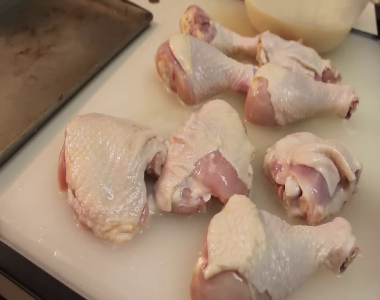

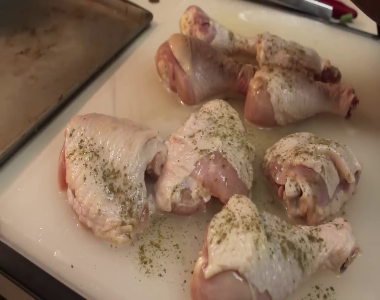

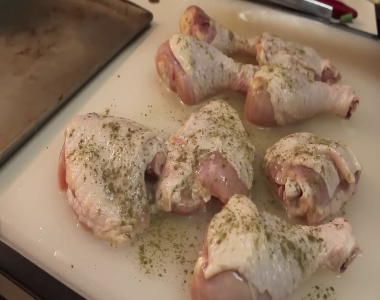

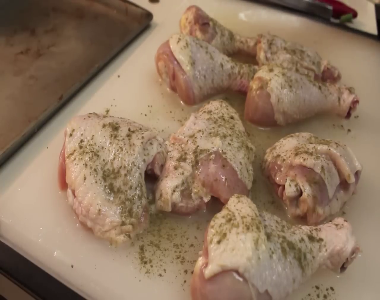

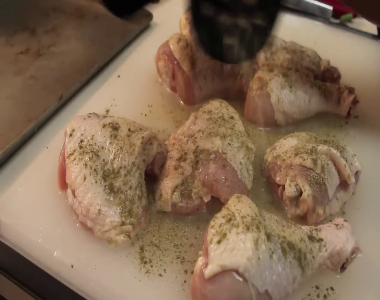

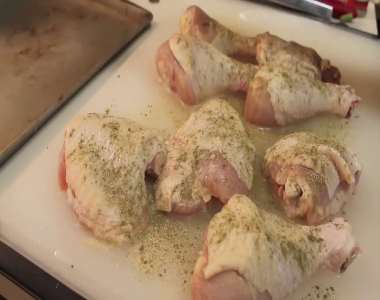

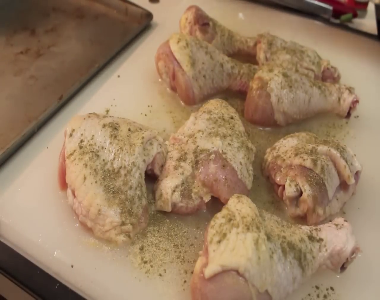

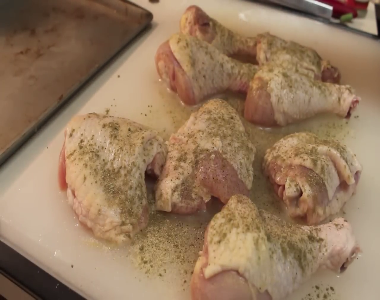

In [ ]:
from google.colab.patches import cv2_imshow
video_file = 'video.mp4'  # Replace with the path to your video file

# Define the start and end times in seconds
start_time = df.iloc[video_id]['segment'][0]  ##eval()  # Start time in seconds
end_time = df.iloc[video_id]['segment'][1]    #eval(df.iloc[collection[0][-1]]['segment'])[1]   # End time in seconds

# Open the video file for reading
cap = cv2.VideoCapture(video_file)

# Check if the video file opened successfully
if not cap.isOpened():
    print("Error: Could not open video file.")
    exit()

# Get the frames per second (fps) of the video
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Calculate the frame numbers for the start and end times
start_frame = int(start_time * fps)
end_frame = int(end_time * fps)

# Set the video capture position to the start frame
cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

# Define the desired low-resolution width and height
low_res_width = 380  # Adjust as needed
low_res_height = 300  # Adjust as needed

# Loop through the frames and display them
count = 0
while cap.isOpened():
  count += 1
  ret, frame = cap.read()

  if count % 50 :
    continue

  if not ret or cap.get(cv2.CAP_PROP_POS_FRAMES) > end_frame:
      break

  # Resize the frame to low resolution
  frame = cv2.resize(frame, (low_res_width, low_res_height))

  cv2_imshow(frame)

  # You can adjust the frame rate by changing the argument to cv2.waitKey
  if cv2.waitKey(10 // fps) & 0xFF == ord('q'):
      break

# Release the video capture object and close the OpenCV window
cap.release()
cv2.destroyAllWindows()